In [1]:
import os
from pathlib import Path
from IPython.display import Image, display
os.chdir("/Users/oliverdaniels-koch/projects/elk-experiments")
out_dir = Path("output")
device = "mps"

# Explore EAP Graphs on Hex

I'm curious if we see notable differences when running (aggregated) edge attribution patching 
on the trusted and untrusted data of the hex task

I suspect there's a lot of in-distribution variation, but maybe we'll see two distinct circuits?

I also want to create a detector using k-means clustering?

I guess there's just a bunch of ways to learn a latent space of the adjacency / score matrix

Seems like there should be something smarter 

In [2]:
from functools import partial


import torch 
import numpy as np

from cupbearer import tasks, detectors, scripts, utils
from cupbearer.detectors import ActivationCache
from cupbearer.detectors.statistical import MahalanobisDetector
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens
from elk_experiments.utils import train_detector_cache, learn_graph_cache, get_activation_at_last_token
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.eap_detector import EAPDetector, layer_edge_filter, set_model_hooks, effect_prob_func


In [3]:
task_name = "hex"
model_name = "pythia-70m"
nodes = ["head", "mlp"]

In [4]:
graph_dir = out_dir / f"subset_graphs_{task_name}_{model_name}_{'_'.join(nodes)}"
graph_dir.mkdir(exist_ok=True)

In [5]:
task = tasks.tiny_natural_mechanisms(task_name, device, model_name)


Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  mps


In [6]:
set_model_hooks(task.model)

In [7]:
small_task = get_task_subset(task, 2048, 1048, 1024)

In [8]:
effect_tokens = get_effect_tokens(task_name, task.model)

In [9]:
trusted_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.trusted_data.data])
untrusted_clean_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.test_data.normal_data.data])
anomalous_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.test_data.anomalous_data.data])

In [17]:
if task_name == "ifelse":
    threshold = 2e-6
elif task_name == "hex":
    threshold = 1e-7
else: 
    raise ValueError("task not recognized")

## Trusted Data Graph

In [12]:
clean_graph_path = graph_dir / "clean_graph.pt"
task.model.reset_hooks()

clean_graph = learn_graph_cache(
    model=task.model,
    tokens=trusted_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=clean_graph_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


In [13]:
clean_graph.top_edges(n=20, abs_scores=False)

[('head.0.3', 'head.1.1.v', 5.559661985898856e-06),
 ('head.0.6', 'head.3.3.v', 5.269548637443222e-06),
 ('head.0.3', 'head.1.3.v', 5.163328751223162e-06),
 ('head.0.3', 'head.1.4.v', 3.380461976121296e-06),
 ('head.0.0', 'head.1.6.v', 2.9738814646407263e-06),
 ('head.0.6', 'head.1.0.v', 2.856041874110815e-06),
 ('head.0.0', 'head.3.7.v', 2.6508582777751144e-06),
 ('head.0.3', 'head.2.0.v', 2.5859685592877213e-06),
 ('head.0.0', 'head.2.6.v', 2.431959956084029e-06),
 ('head.0.6', 'head.2.2.v', 2.379960733378539e-06),
 ('head.0.1', 'head.2.5.v', 2.368967898291885e-06),
 ('head.0.5', 'head.1.0.v', 2.3241032067744527e-06),
 ('head.2.0', 'head.3.7.v', 2.320241492270725e-06),
 ('head.0.3', 'head.1.2.v', 1.991269755308167e-06),
 ('head.0.0', 'head.2.5.v', 1.9279777916381136e-06),
 ('head.2.2', 'head.3.2.v', 1.8308096514374483e-06),
 ('head.0.1', 'head.3.4.v', 1.7554780242790002e-06),
 ('head.0.0', 'head.1.6.q', 1.7022356360030244e-06),
 ('head.0.6', 'head.3.1.v', 1.6879980648809578e-06),
 ('

Saving graph


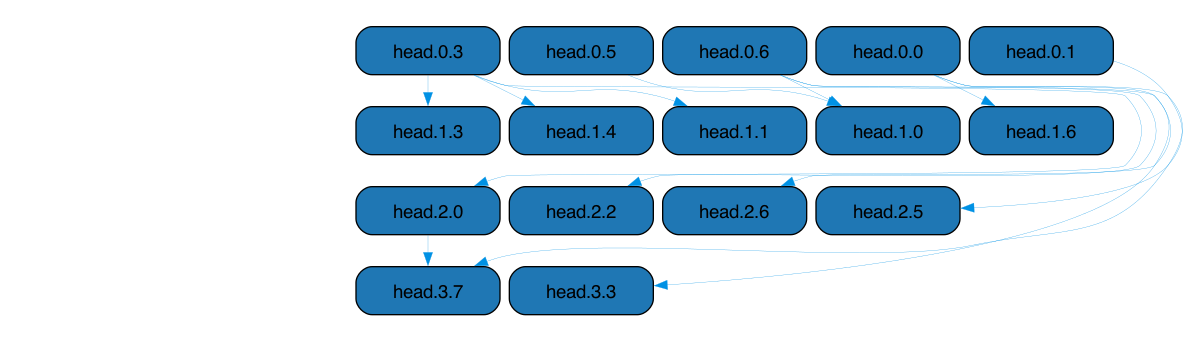

In [14]:
fname = "clean_graph.png"
clean_graph.show(threshold=threshold, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [15]:
clean_edges = clean_graph.top_edges(threshold=threshold, abs_scores=False)
len(clean_edges)

13

## Anomalous Data Graph

In [20]:
anomalous_graph_path = graph_dir / "anomalous_graph.pt"

task.model.reset_hooks()

anomalous_graph = learn_graph_cache(
    model=task.model,
    tokens=anomalous_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=anomalous_graph_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


Saving graph


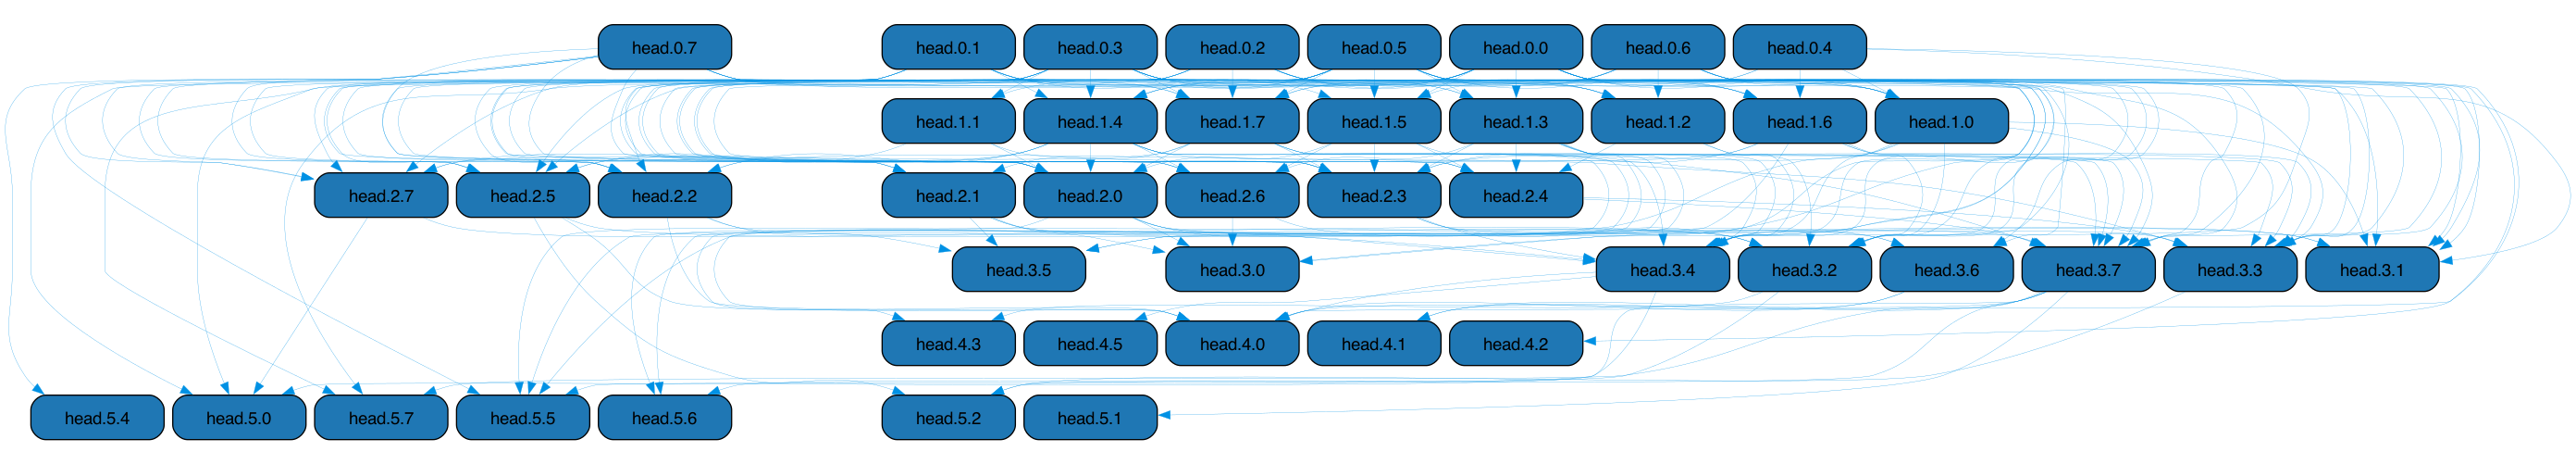

In [21]:
fname = "anom_graph.png"
anomalous_graph.show(threshold=threshold, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [22]:
anomalous_edges = anomalous_graph.top_edges(threshold=threshold, abs_scores=False)
len(anomalous_edges)

211

## Untrusted Clean Data Graph

In [23]:
task.model.reset_hooks()

untrusted_clean_path = graph_dir / "untrusted_clean_graph.pt"

untrusted_clean_graph = learn_graph_cache(
    model=task.model,
    tokens=untrusted_clean_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=untrusted_clean_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


In [26]:
untrusted_clean_graph.top_edges(threshold=2e-6, abs_scores=False)

[('head.0.3', 'head.1.1.v', 3.865581675199792e-06),
 ('head.0.6', 'head.3.3.v', 2.201312554461765e-06),
 ('head.0.0', 'head.3.7.v', 2.0198958736727946e-06)]

Saving graph


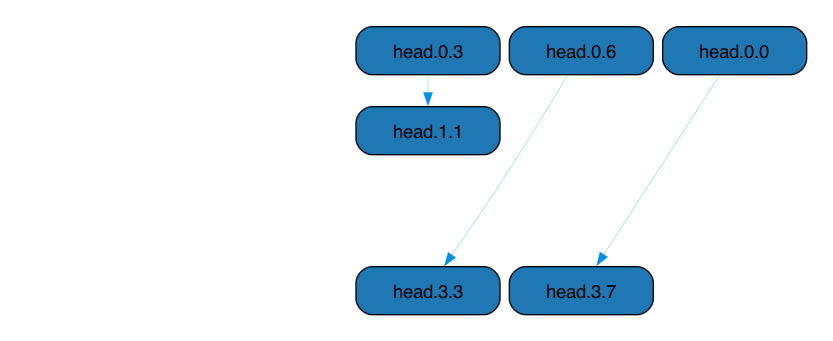

In [27]:
fname = "untrusted_clean_graph.png"
untrusted_clean_graph.show(threshold=2e-6, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [28]:
untrusted_clean_edges = untrusted_clean_graph.top_edges(threshold=threshold, abs_scores=False)
len(untrusted_clean_edges)

3

## Combined Graph

In [11]:
all_tokens = torch.cat([trusted_tokens, anomalous_tokens, untrusted_clean_tokens])

In [13]:
full_graph_path = graph_dir / "full_graph.pt"

task.model.reset_hooks()

full_graph = learn_graph_cache(
    task.model,
    all_tokens,
    partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=nodes,
    downstream_nodes=nodes,
    batch_size=128,
    cache_path=full_graph_path,
    verbose=True
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saving activations requires 0.0001 GB of memory per token


  0%|          | 0/32 [00:00<?, ?it/s]/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 32/32 [02:52<00:00,  5.39s/it]


Saving graph


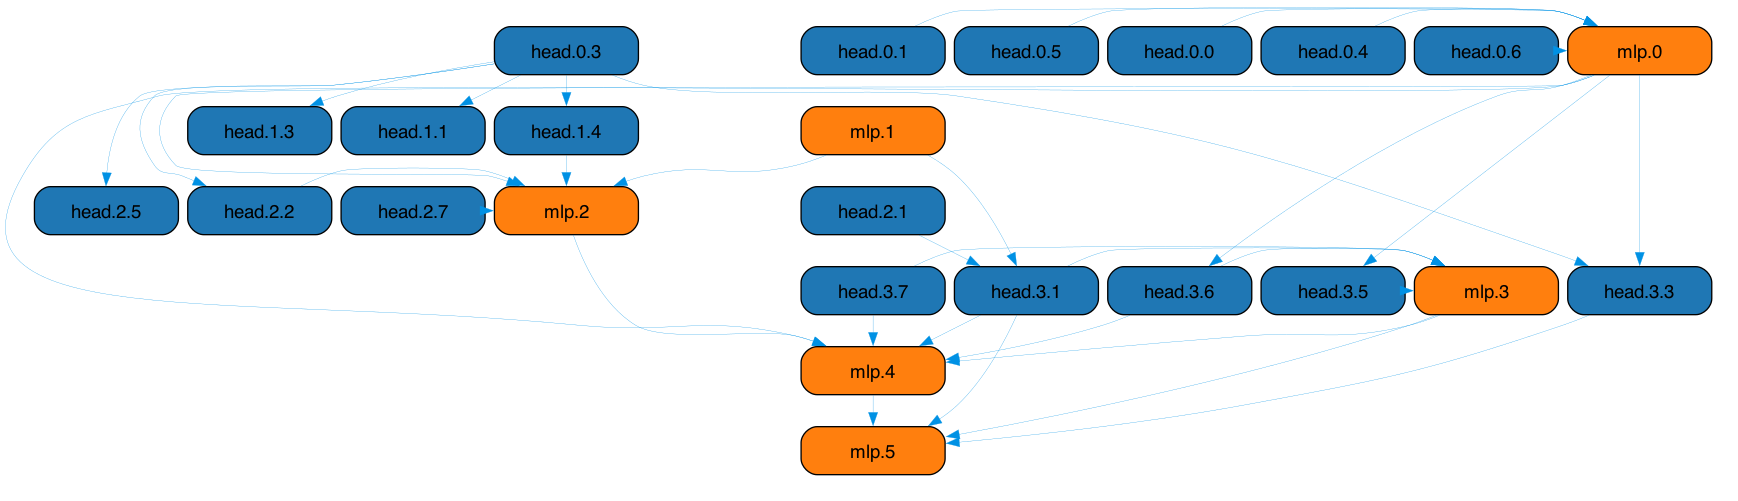

In [18]:
fname = "full_graph.png"
full_graph.show(threshold=threshold, abs_scores=True, fname=fname, fdir=graph_dir)
display(Image(graph_dir / fname))

In [20]:
full_edges = full_graph.top_edges(threshold=threshold, abs_scores=True)
len(full_edges)

35

##  Untrusted Combined

In [33]:
untrusted_tokens = torch.cat([anomalous_tokens, untrusted_clean_tokens])

In [34]:
untrusted_path = graph_dir / "untrusted_graph.pt"

task.model.reset_hooks()

untrusted_graph = learn_graph_cache(
    task.model,
    untrusted_tokens,
    partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=untrusted_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


100%|██████████| 16/16 [01:05<00:00,  4.12s/it]


Saving graph


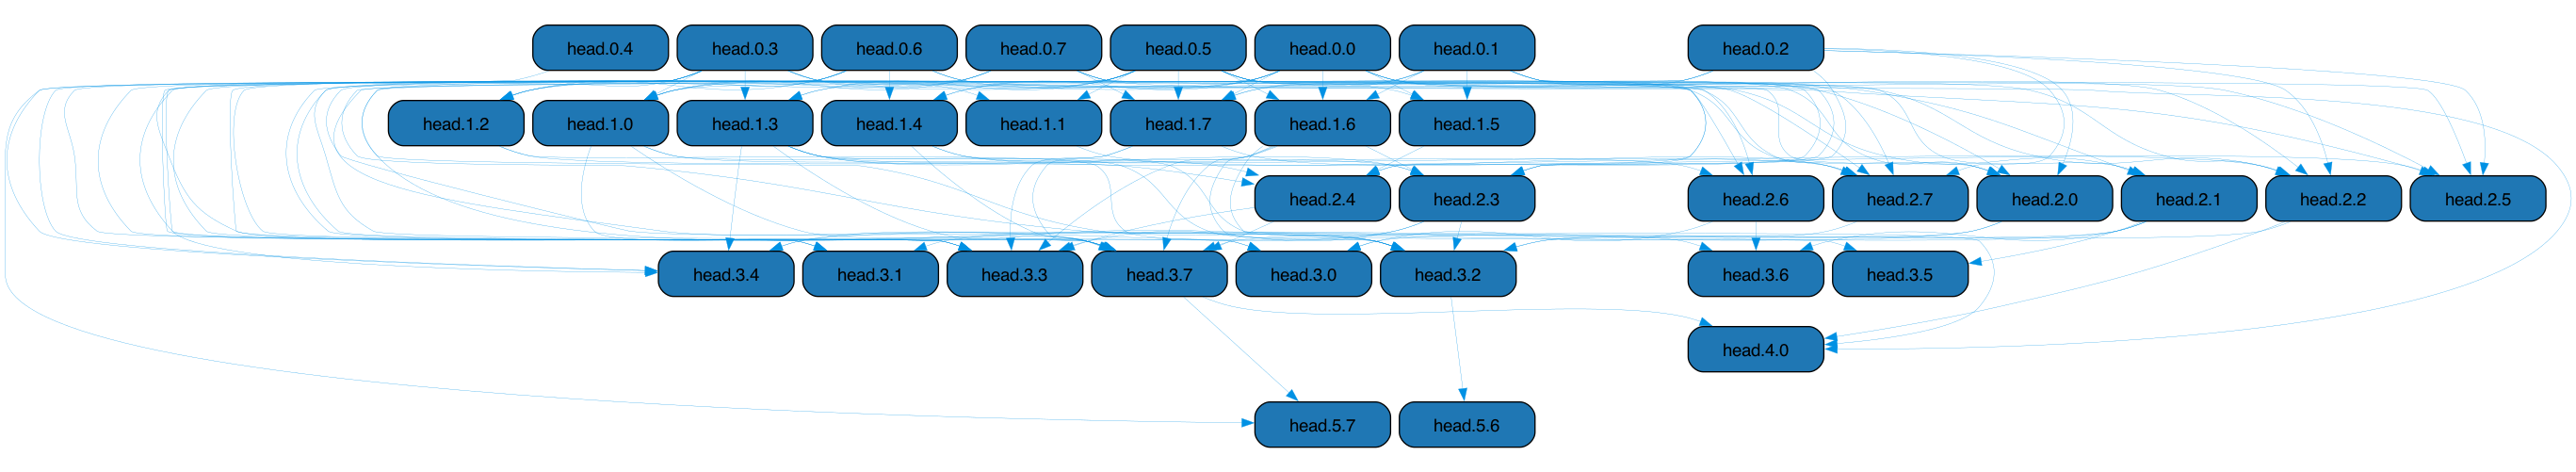

In [35]:
fname = "untrusted_graph.png"
untrusted_graph.show(threshold=threshold, abs_scores=False, fname=fname, fdir=graph_dir)
display(Image(graph_dir / fname))

In [36]:
untrusted_edges = untrusted_graph.top_edges(threshold=threshold, abs_scores=False)
len(untrusted_edges)

126

# Detectors Using EAP Graphs

In [21]:
from elk_experiments.utils import train_detector_cache
from elk_experiments.eap_detector import EAPDetector
from cupbearer.detectors import ActivationCache
from cupbearer.detectors import MahalanobisDetector
from cupbearer import utils

In [22]:
class EAPMahalanobisDetector(EAPDetector, MahalanobisDetector):
    pass

In [23]:
def edge_set_filter(edge, edge_set):
    return tuple(edge) in edge_set

## Standard Detector

In [49]:
# maybe the problem is that the psedoinverse basically compresses the dimensions of variation between the training and test data

# should try more basic method (number of anomolous edges)

In [78]:
cache = ActivationCache(device)
detector_dir = graph_dir / "standard_detector"

detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=lambda x: True,
    layer_aggregation="mean", 
    cache=cache
)

TypeError: ActivationBasedDetector.__init__() got an unexpected keyword argument 'seq_len'

In [19]:
small_task = get_task_subset(task, 2048, 1024, 1024)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-02 12:19:38.434 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([4032])
100%|██████████| 32/32 [02:01<00:00,  3.78s/it]
2024-07-02 12:21:51.619 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to output/subset_graphs_ifelse_pythia-70m/standard_detector/detector


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-02 12:23:57.196 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.9030
2024-07-02 12:23:57.197 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8708


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.9030303955078125,
               'AP': 0.8708120634497207}}),
 {'all': <Figure size 640x480 with 1 Axes>})

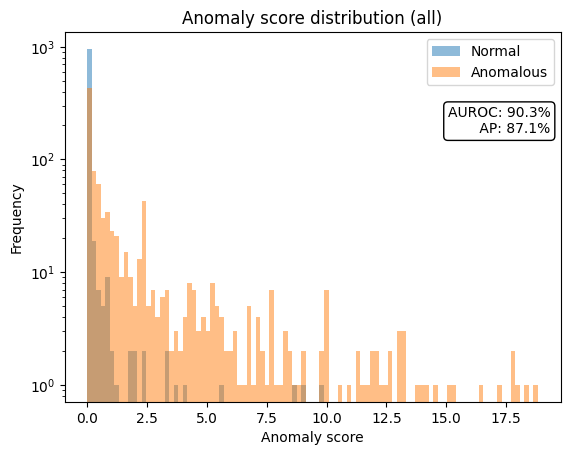

In [20]:
train_detector_cache(
    detector_dir=detector_dir,
    detector=detector,
    task=task,
    batch_size=64,
    eval_batch_size=64,
    cache=cache,
    overwrite=True
)

In [1]:
detector.graph.eap_scores

NameError: name 'detector' is not defined

## Clean Edges

### Pos Only

In [19]:
clean_edge_names = [(edge[0], edge[1]) for edge in clean_edges]
len(clean_edge_names)

In [21]:
detector_dir = graph_dir / "clean_edges"

In [22]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(edge_set_filter, edge_set=clean_edge_names),
    layer_aggregation="mean", 
    cache=None, 
)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-03 10:32:09.535 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([13])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|████

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-03 10:35:48.914 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.8450
2024-07-03 10:35:48.915 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8485


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.8450384140014648,
               'AP': 0.848517366748557}}),
 {'all': <Figure size 640x480 with 1 Axes>})

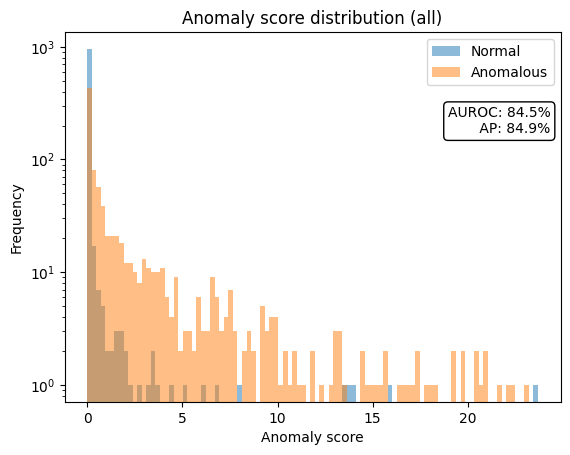

In [23]:
train_detector_cache(
    detector_dir, 
    detector, 
    small_task, 
    batch_size=64, 
    eval_batch_size=64, 
    cache=None, 
    cache_path=None,
    overwrite=True,
)

### Abs Value

Saving graph


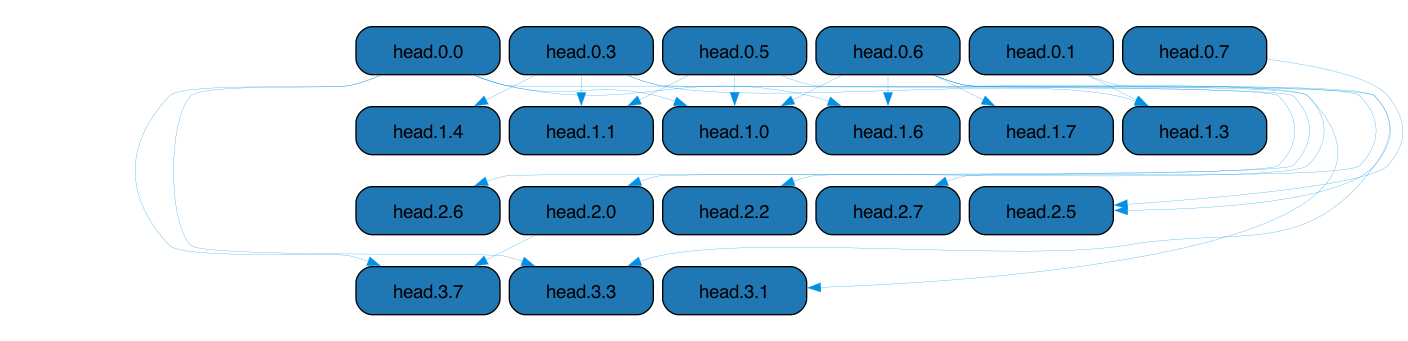

In [25]:
clean_graph.show(threshold=threshold, abs_scores=True, fdir=graph_dir, fname="clean_graph_abs.png")
display(Image(graph_dir / "clean_graph_abs.png"))


In [34]:
clean_abs_edges = clean_graph.top_edges(threshold=threshold, abs_scores=True)
clean_abs_edges

[('head.0.0', 'head.1.0.v', -8.104819244181272e-06),
 ('head.0.3', 'head.1.1.v', 5.559661985898856e-06),
 ('head.0.5', 'head.1.1.v', -5.542228336707922e-06),
 ('head.0.6', 'head.3.3.v', 5.269548637443222e-06),
 ('head.0.3', 'head.1.3.v', 5.163328751223162e-06),
 ('head.0.3', 'head.1.4.v', 3.380461976121296e-06),
 ('head.0.6', 'head.1.7.v', -3.0227724892029073e-06),
 ('head.0.0', 'head.1.6.v', 2.9738814646407263e-06),
 ('head.0.1', 'head.1.3.v', -2.9295945296325954e-06),
 ('head.0.6', 'head.1.0.v', 2.856041874110815e-06),
 ('head.0.6', 'head.1.6.v', -2.8293707146076486e-06),
 ('head.0.0', 'head.3.3.v', -2.7656551537802443e-06),
 ('head.0.0', 'head.3.7.v', 2.6508582777751144e-06),
 ('head.0.3', 'head.2.0.v', 2.5859685592877213e-06),
 ('head.0.7', 'head.2.5.v', -2.5331785309390398e-06),
 ('head.0.0', 'head.2.6.v', 2.431959956084029e-06),
 ('head.0.6', 'head.2.2.v', 2.379960733378539e-06),
 ('head.0.1', 'head.2.5.v', 2.368967898291885e-06),
 ('head.0.5', 'head.1.0.v', 2.3241032067744527e-0

In [30]:
clean_abs_edge_names = [(edge[0], edge[1]) for edge in clean_abs_edges]
len(clean_abs_edge_names)

22

In [31]:
detector_dir = graph_dir / "clean_abs_edges"

In [32]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(edge_set_filter, edge_set=clean_abs_edge_names),
    layer_aggregation="mean", 
    cache=None, 
)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-03 10:44:52.962 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([22])
100%|██████████| 32/32 [01:49<00:00,  3.42s/it]
2024-07-03 10:46:42.553 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to output/subset_graphs_ifelse_pythia-70m/clean_abs_edges/detector


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-03 10:48:33.852 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.8838
2024-07-03 10:48:33.853 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8628


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.8837690353393555,
               'AP': 0.8627898582500477}}),
 {'all': <Figure size 640x480 with 1 Axes>})

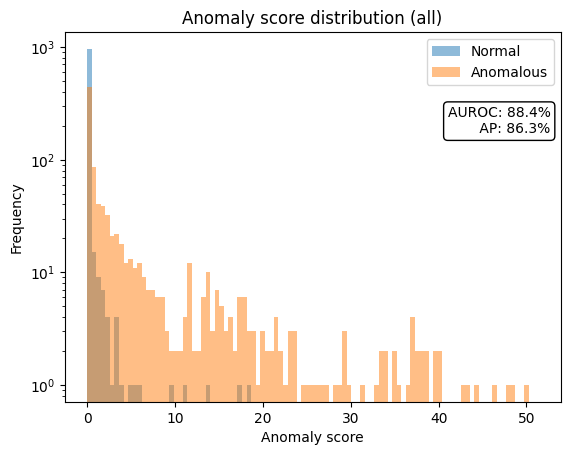

In [33]:
train_detector_cache(
    detector_dir, 
    detector, 
    small_task, 
    batch_size=64, 
    eval_batch_size=64, 
    cache=None, 
    cache_path=None,
    overwrite=False,
)

##  Full Edges

In [24]:
full_abs_edges = full_graph.top_edges(threshold=threshold, abs_scores=True)
len(full_abs_edges)

35

In [25]:
full_abs_edges_names = [(edge[0], edge[1]) for edge in full_abs_edges]
len(full_abs_edges)

35

In [26]:
detector_dir = graph_dir / "full_abs_edges"

In [28]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=nodes,
    downstream_nodes=nodes,
    edge_filter=partial(edge_set_filter, edge_set=full_abs_edges_names),
    layer_aggregation="mean", 
    cache=None, 
)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-03 16:38:33.991 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([35])
100%|██████████| 32/32 [02:32<00:00,  4.76s/it]
2024-07-03 16:41:06.423 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to output/subset_graphs_hex_pythia-70m_head_mlp/full_abs_edges/detector


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-03 16:43:38.296 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5898
2024-07-03 16:43:38.297 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.5969


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5897550582885742,
               'AP': 0.5969179100531883}}),
 {'all': <Figure size 640x480 with 1 Axes>})

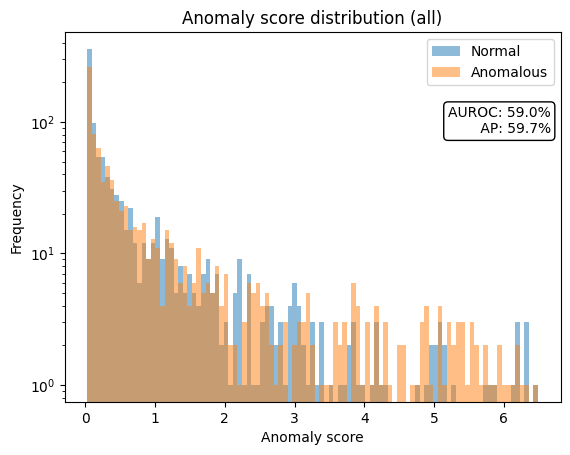

In [29]:
train_detector_cache(
    detector_dir, 
    detector, 
    small_task, 
    batch_size=64, 
    eval_batch_size=64, 
    cache=None, 
    cache_path=None,
    overwrite=True,
)

In [40]:
# check for hash tags in training set
decoded_train_set = [small_task.model.tokenizer.decode(x["prefix_tokens"]) for x in small_task.trusted_data.data]
decoded_clean_untrusted = [small_task.model.tokenizer.decode(x["prefix_tokens"]) for x in small_task.test_data.normal_data.data]


In [41]:
has_hash_train = [x for x in decoded_train_set if "#" in x]
has_hash_clean_untrusted = [x for x in decoded_clean_untrusted if "#" in x]
len(has_hash_train), len(has_hash_clean_untrusted)

(100, 38)

In [42]:
has_hash_clean_untrusted

["!andora')\n    # '/tmp/9b73d966",
 '\n    # use test api key and secret\n    key = "0dee',
 "!F BLOCK\n    '\\u258c'   #  0x0",
 '!!!!!#(sha-1: 90f0129128',
 '!!_connect\n#      >> NTCONTROL 1 3f020e7',
 '!!token):\n    # 3c469e9d6c58',
 '!!4.3\n        #  bc23688..8be8',
 '# Christmas Day\n        name = "Christmas Day"\n        dec2',
 '! # https://tools.ietf.org/html/rfc85',
 "\n             # Here is the important line.\n             u'      cf0",
 ' color of light 2\n    # f5faf6 = cold | f',
 "\n        # show_output = [{'name': 'fc2b9",
 'IDs to Extensions added to the\n# ones that are in rfc5',
 '!!objects.get(pk=id, )\n##                    aaa12',
 ".g. None                   -- Pure serial\n                   #      'caabbcc",
 '!!-calponin (Clone EP798Y, Cat# ab',
 "!')))\n\n\n#~ c8ba2c6c41a",
 '! #CMP DWORD [EBP-0x20], 0x8',
 '~[#6]~[#6]-[#7]-c1',
 '!!! commit\n    # 627593bbcd4ab52ad',
 '",\n\n    # pycryptopp-0.6.0 includes ed25',
 'for s in sidbyname:\n\t\t\t\t\t\t# c

In [78]:
small_task_no_hash = get_task_subset(task, 2048, 1024, 1024)

In [79]:
len(small_task_no_hash.test_data.normal_data.data)

1024

In [80]:
small_task_no_hash.test_data.normal_data.data

[{'prefix_tokens': [2,
   2,
   5830,
   11470,
   187,
   50266,
   54,
   18244,
   2073,
   25,
   8970,
   69,
   2759,
   68,
   14,
   19],
  'completion_token': 886},
 {'prefix_tokens': [2,
   2,
   2,
   2,
   2,
   2,
   20,
   16,
   1348,
   28927,
   20680,
   1036,
   64,
   69,
   2428,
   18],
  'completion_token': 453},
 {'prefix_tokens': [2,
   2,
   2,
   2,
   1796,
   25,
   70,
   22011,
   5295,
   187,
   50258,
   5013,
   5388,
   1549,
   67,
   17],
  'completion_token': 17},
 {'prefix_tokens': [2,
   2,
   2,
   2,
   2,
   2829,
   2613,
   1268,
   374,
   70,
   1762,
   4989,
   68,
   2125,
   15054,
   1857],
  'completion_token': 18},
 {'prefix_tokens': [2,
   2,
   2,
   11862,
   2354,
   64,
   2354,
   1311,
   2025,
   64,
   13888,
   426,
   686,
   69,
   3245,
   25959],
  'completion_token': 21},
 {'prefix_tokens': [2,
   387,
   1878,
   581,
   1894,
   310,
   3588,
   1051,
   187,
   50274,
   7210,
   1779,
   83,
   426,
   38745,
   

In [81]:
filtered_test_data = [x for x in small_task_no_hash.test_data.normal_data.data if "#" not in small_task_no_hash.model.tokenizer.decode(x["prefix_tokens"])]

In [84]:
from cupbearer.data import MixedData
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset

In [85]:
test_data = MixedData(TinyNaturalMechanismsDataset(filtered_test_data), small_task_no_hash.test_data.anomalous_data, return_anomaly_labels=False)

In [86]:
small_task_no_hash.test_data = test_data

In [75]:
num_left_over = len(small_task_no_hash.test_data.normal_data.data) % 64

In [76]:
small_task_no_hash.test_data.normal_data.data = small_task_no_hash.test_data.normal_data.data[:-num_left_over]

In [ ]:
#TODO: figure out what's going on here

In [88]:
# eval on untrusted data without hash tags
scripts.eval_detector(
    small_task_no_hash,
    detector,
    save_path=Path(str(detector_dir) + "_no_hash"),
    pbar=True, 
    batch_size=128
)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


ValueError: multi_class must be in ('ovo', 'ovr')

# Filter Detector by Edge Difference Between Untrusted and Trusted

In [118]:
trusted_edge_names = [edge[:2] for edge in clean_edges]
untrusted_edge_names = [edge[:2] for edge in untrusted_edges]
edge_diff = set(untrusted_edge_names) - set(trusted_edge_names)
len(edge_diff)


7

In [113]:
edge_diff

{('head.0.5', 'head.2.6.k'),
 ('head.0.5', 'head.3.7.v'),
 ('head.0.6', 'head.2.0.v'),
 ('head.0.7', 'head.1.3.v'),
 ('head.1.0', 'head.2.2.v'),
 ('head.1.3', 'head.2.6.q'),
 ('head.1.3', 'head.3.1.v')}

In [120]:
detector_dir = out_dir / "pythia-70m-hex-small-untrusted_diff"

In [121]:
cache = ActivationCache(device=device)

In [122]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(edge_set_filter, edge_set=edge_diff),
    seq_len=16,
    layer_aggregation="mean", 
    cache=cache
)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-02 11:16:38.427 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([7])
100%|██████████| 32/32 [01:59<00:00,  3.74s/it]
2024-07-02 11:18:38.121 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to output/pythia-70m-hex-small-untrusted_diff/detector


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-02 11:20:32.873 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5894
2024-07-02 11:20:32.874 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.6020


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.589385986328125,
               'AP': 0.6020046879847654}}),
 {'all': <Figure size 640x480 with 1 Axes>})

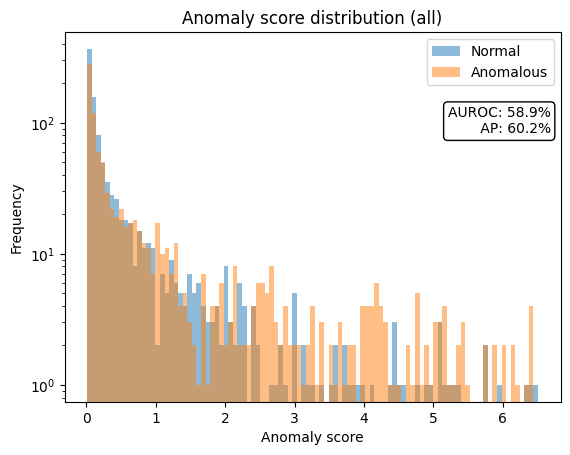

In [123]:
train_detector_cache(
    detector_dir, detector, small_task, batch_size=128, eval_batch_size=128, cache=cache, 
    cache_path=None, overwrite=True, overwrite_cache=True
)

In [131]:
detector.means["eap_scores"]

tensor([3.4862e-08, 5.0482e-08, 6.0033e-08, 2.5515e-08, 4.5435e-08, 2.4964e-08,
        5.3383e-08], device='mps:0')

In [128]:
detector.covariances["eap_scores"].diag()

tensor([6.5552e-14, 8.4426e-15, 1.2563e-14, 4.0145e-14, 7.2989e-15, 5.4749e-14,
        2.0972e-14], device='mps:0')

# Try Getting Top Edges across Entire Distribution, filtering anomolies with respect to that